In [ ]:
#Analysis for comparing results of morphological data in BIN and MULTI representation
#Consider the LH of the tree found with BIN alignment under the MULTI alignment and model
#and the other way around

In [27]:
import os
import pandas as pd
from ete3 import Tree
import matplotlib.pyplot as plt
from Bio import AlignIO
from Bio.AlignIO.PhylipIO import RelaxedPhylipWriter
from Bio.SeqRecord import SeqRecord
from Bio.Align import MultipleSeqAlignment

morph_data_multistate = pd.read_parquet("training_data/morph_data_multistate.parquet")
morph_data_binarized = pd.read_parquet("training_data/morph_data_binarized.parquet")

states = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "A", "B", "C", "D", "E", "F", "G", "H", "I", "J", "K", "L", "M", "N", "O", "P", "Q", "R", "S", "T", "U", "V", "W", "X", "Y", "Z", "!", "\"", "#", "$", "%", "&", "'", "(", ")", "*", "+",
",", "/", ":", ";", "<", "=", ">", "@", "[", "\\", "]", "^", "_", "{", "|", "}", "~"]
idx_for_state = {}
for i, state in enumerate(states):
    idx_for_state[state] = i
idx_for_state['-'] = -1
idx_for_state['?'] = -1

def determine_num_states():
    d = "morph_alignments/multi/"
    align_num_states = {}
    row_num_states = {}
    column_num_states = {}
    with os.scandir(d) as it:
        for entry in it:
            if not entry.is_file():
                continue
            align = AlignIO.read(os.path.join(d, entry.name), "phylip-relaxed")
            column_maxima = [max([idx_for_state[char] + 1for char in rec.seq]) for rec in align]
            row_num_states[entry.name] = column_maxima
            align_num_states[entry.name] = max(column_maxima)
            column_num_states[entry.name] = [max([idx_for_state[record.seq[c]] + 1 for record in align]) for c in range(len(align[0].seq))]
    return (row_num_states, column_num_states, align_num_states)
            
            
def write_num_states():
    (_, _, num_states) = determine_num_states()
    outfile = open("temp/max_states.csv", 'w+')
    outfile.write("name,states\n")
    for (name, num) in num_states:
        outfile.write(name+"," + str(num) +"\n")
        
def plot_num_states():
    (row_wise, col_wise, align_wise) = determine_num_states()
    row_values = []
    col_values = []
    align_values = []
    for (name, col_maxima) in col_wise.items():
        col_values += col_maxima
        align_values.append(align_wise[name])
        row_values += (row_wise[name])
        
    plt.xlabel("max number of states")
    plt.ylabel("number of columns")
    plt.hist(col_values, bins=10)
    plt.show()
    
    plt.xlabel("max number of states")
    plt.ylabel("number of rows")
    plt.hist(row_values, bins=10)
    plt.show()
    
    plt.xlabel("max number of states")
    plt.ylabel("number of aligns")
    plt.hist(align_values, bins=10)
    plt.show()
            

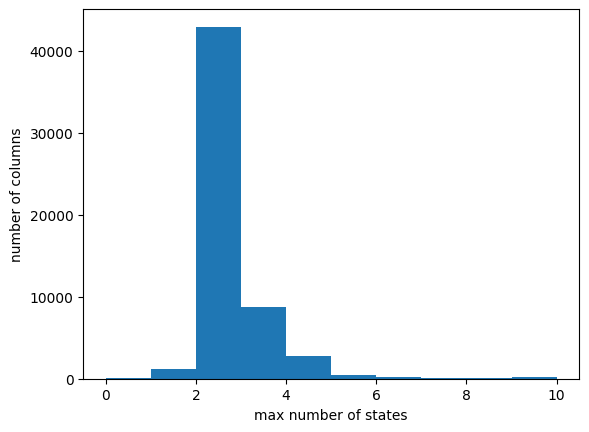

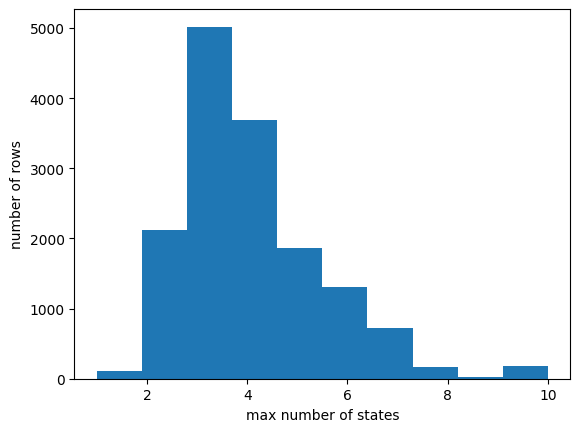

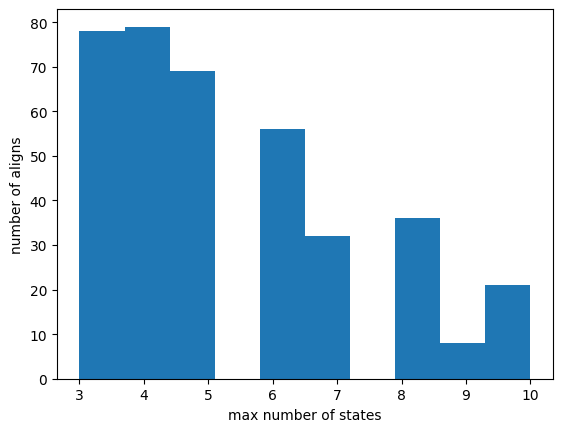

In [28]:
plot_num_states()

In [1]:
def determine_num_states():
    d = "alignments/multi/"
    outfile = open("temp/max_states.csv", 'w+')
    outfile.write("name,states\n")
    with os.scandir(d) as it:
        for entry in it:
            if not entry.is_file():
                continue
            align = AlignIO.read(os.path.join(d, entry.name), "phylip-relaxed")
            max_state = 1
            for rec in align:
                for char in rec.seq:
                    if char == '-' or char=='?':
                        continue
                    max_state = max(max_state, idx_for_state[char] + 1)
            outfile.write(entry.name+"," + str(max_state) +"\n")
            
def read_num_states():
    lines = open("temp/max_states.csv", 'r').read().split("\n")[1:-1]
    num_states = {}
    for line in lines:
        data = line.split(",")
        num_states[data[0]] = int(data[1])
    return num_states

def eval_lh(tree, name, model):
    tree.write(outfile="temp.tree")
    if model.startswith("BIN"):
        alignment_name = "morph_alignments/bin/" + name
    else:
        alignment_name = "morph_alignments/multi/" + name
    os.system('./../tools/raxml-ng/build/bin/raxml-ng --evaluate --msa ' + alignment_name +
            ' --threads 2 --model ' + model + ' --tree temp.tree --prefix foo --nofiles' +
              " --opt-branches off " + '> out.txt')
    l_file = open('out.txt', 'r')
    lines = l_file.readlines()
    lh = 0
    for line in lines:
        if(line.startswith('Final LogLikelihood:')):
            lh = float(line.split(" ")[2].strip())
    os.remove("out.txt")
    os.remove("temp.tree")
    return lh


def calculate_cross_lhs():
    num_states_dict = read_num_states()
    lh_file = open("temp/lhs.csv", "w+")
    lh_file.write("alignment,eval_tree,model,lh\n")
    for index, row in morph_data_multistate.iterrows():
        multitree = Tree(row["newick_eval"])
        multiname = row['verbose_name']
        num_states = num_states_dict[multiname]
        multimodel = "MULTI" + str(num_states) + "_GTR"
        binname = multiname.split('.')[0] + ".BIN.phy"
        bintree =  Tree(morph_data_binarized.loc[(morph_data_binarized['verbose_name'] == binname)].iloc[0]["newick_eval"])
        bamt_lh =  eval_lh(multitree, binname, "BIN")
        lh_file.write(binname + "," + multiname + ",BIN," + str(bamt_lh) + "\n")
        mabt_lh = eval_lh(bintree, multiname, multimodel)
        lh_file.write(multiname + "," + binname + "," + multimodel + "," + str(mabt_lh) + "\n")

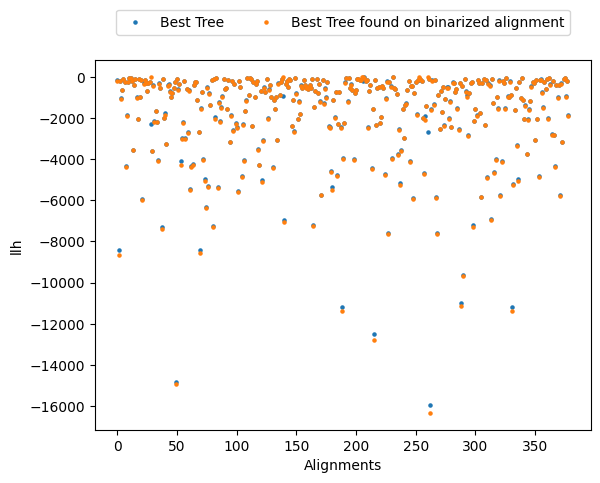

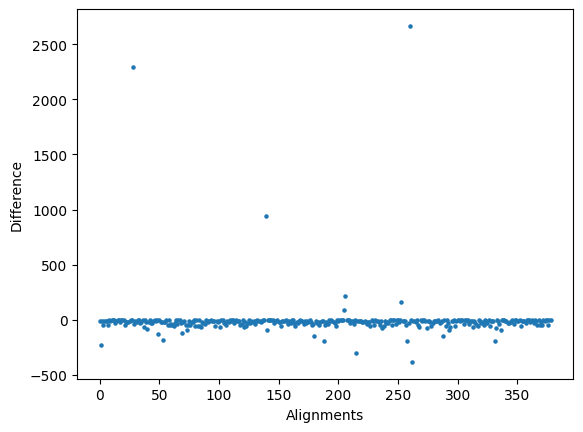

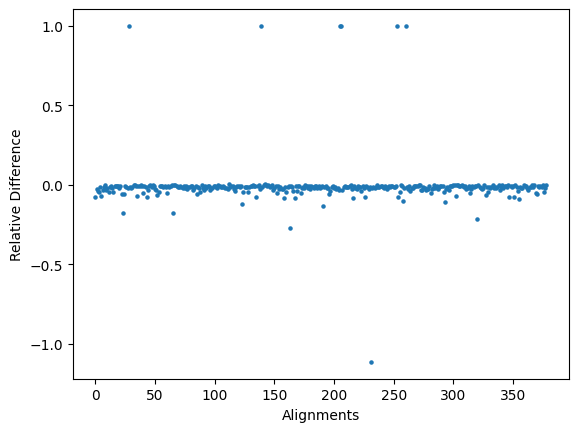

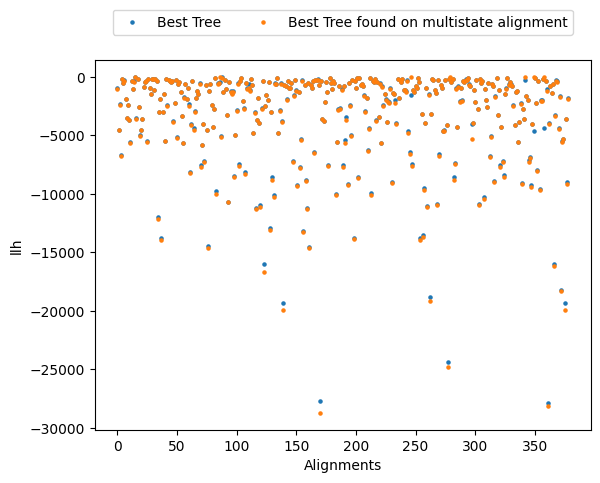

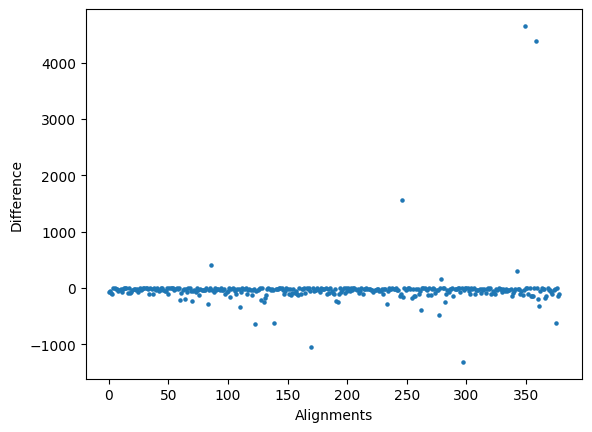

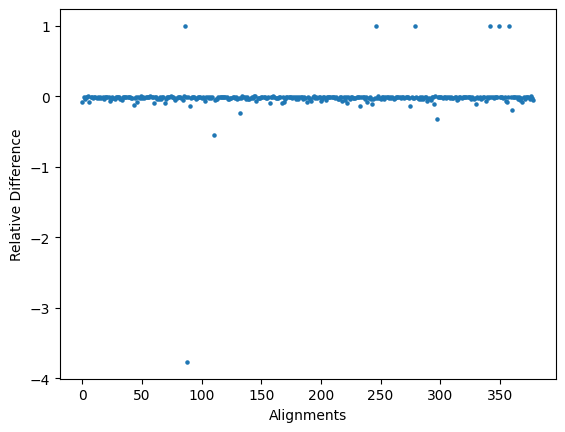

In [2]:
def comparison_with_cross_lhs():
    cross_llh_dict = {}
    lines = open("temp/lhs.csv", "r").read().split("\n")[1:-1]
    for line in lines:
        data = line.split(",")
        assert(data[0] not in cross_llh_dict)
        cross_llh_dict[data[0]] = float(data[3])
    multi_eval_llhs = []
    multi_cross_llhs = []
    multi_diffs = []
    multi_diffs_rel = []
    for index, row in morph_data_multistate.iterrows():
        llh_eval = row["llh_eval"]
        llh_cross = cross_llh_dict[row['verbose_name']]
        diff = llh_cross - llh_eval
        rel_diff = -diff/llh_eval
        multi_eval_llhs.append(llh_eval)
        multi_cross_llhs.append(llh_cross)
        multi_diffs.append(diff)
        multi_diffs_rel.append(rel_diff)
    n = len(multi_eval_llhs) 
    
    plt.scatter(range(n), multi_eval_llhs, label="Best Tree", s=5)
    plt.scatter(range(n), multi_cross_llhs, label="Best Tree found on binarized alignment", s=5)
    plt.legend(loc='lower center', bbox_to_anchor=(0.5, 1.05), ncol=2)
    plt.xlabel("Alignments")
    plt.ylabel("llh")
    plt.show()
    
    plt.scatter(range(n), multi_diffs, s=5)
    plt.xlabel("Alignments")
    plt.ylabel("Difference")
    plt.show()
    
    plt.scatter(range(n), multi_diffs_rel, s=5)
    plt.xlabel("Alignments")
    plt.ylabel("Relative Difference")
    plt.show()
    
    bin_eval_llhs = []
    bin_cross_llhs = []
    bin_diffs = []
    bin_diffs_rel = []
    for index, row in morph_data_binarized.iterrows():
        llh_eval = row["llh_eval"]
        llh_cross = cross_llh_dict[row['verbose_name']]
        diff = llh_cross - llh_eval
        rel_diff = -diff/llh_eval
        bin_eval_llhs.append(llh_eval)
        bin_cross_llhs.append(llh_cross)
        bin_diffs.append(diff)
        bin_diffs_rel.append(rel_diff)
        
    plt.scatter(range(n), bin_eval_llhs, label="Best Tree", s=5)
    plt.scatter(range(n), bin_cross_llhs, label="Best Tree found on multistate alignment", s=5)
    plt.legend(loc='lower center', bbox_to_anchor=(0.5, 1.05), ncol=2)
    plt.xlabel("Alignments")
    plt.ylabel("llh")
    plt.show()
    
    plt.scatter(range(n), bin_diffs, s=5)
    plt.xlabel("Alignments")
    plt.ylabel("Difference")
    plt.show()
    
    plt.scatter(range(n), bin_diffs_rel, s=5)
    plt.xlabel("Alignments")
    plt.ylabel("Relative Difference")
    plt.show()
comparison_with_cross_lhs()
